In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 기본 한글 폰트 설정 (시각화 한글 깨짐 방지)
plt.rcParams['font.family'] = 'Malgun Gothic'
# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 비활성시간때의 따릉이 수요가 제일 불균형한 지역 선별
1. K-means를 이용해서 각 자치구들을 클러스터링
2. 클러스터링 결과론 나온 각 클러스터들의 특징을 파악
3. 클러스터의 특징을 파악을 통해서 불균형 클러스터 선별

In [4]:
df = pd.read_csv("./data/columns/merged_비활성시간.csv")

## 각 컬럼 소개
1. 자치구 - 자치구
2. 시간_구분 - 이용량을 기준으로 시간을 나눔
    - 활성시간 : 이용량이 제일 많은 시간때(8, 16, 17, 18, 19, 20)
    - 비활성시간 : 이용량이 제일 적은 시간떄( 1, 2, 3, 4, 5, 23)
    - 중간시간 : 이용량이 중간인 시간때(0, 6, 7, 9, 10, 11, 12, 13, 14, 15, 21, 22)
3. 대여_건수 : 따릉이의 대여건수 (개)
4. 반납_건수 : 따릉이의 반납건수 (개)
5. |대여-반납| : 대여건수와 반납 건수의 차이(각 자치구마다의 대여건수와 반납건수의 차이) (개)
6. 빈대여소의비율 : 각 시간때의 자치구마다의 빈대여소의 수 / 자치구의 전체 대여소의 수를 구한 뒤 시간_구분의 시간때의 평균 (%)
7. std : 빈 대여소의 시간으로 묶은 값의 표준편차
8. 빈대여소시간 : 각 자치구마다 빈 대여소가 몇시간 있는지 (시간)
9. 유출량 : 자치구에서 다른 자치구로 유출된 따릉이의 갯수 (개)
10. 유입량 : 자치구에서 다른 자치구로 부터 유입된 따릉이의 갯수 (개)
11. 회전율 : (대여건수 + 반납건수) / 각 자치구의 대여소의 수(얼마나 따릉이가 활발하게 사용되는지)
12. 최대 이용량 : 24시간중 가장 따릉이가 많이 이용된 갯수 (개)
13. 최소 이용량 : 24시간중 가장 따릉이가 적게 이용된 갯수 (개)
14. 최대최소_편차 : 최대이용량 - 최소이용량 (개)
15. 대여소의 개수 : 각 자치구마다의 대여소의 갯수 (개)
16. 면적 : 자치구의 면적 (km²)
17. 밀도 : 자치구의 대여소의 갯수 / 자치구의 면적 (개/km²)
18. 이동량 : |유입량 - 유출량|, 다른 자치구로부터 따릉이가 얼마나 이동했는지 (개)

In [7]:
df.head()

,자치구,시간_구분,대여_건수,반납_건수,|대여-반납|,빈대여소의비율,std,빈대여소시간,유출량,유입량,회전율,최대이용량,최소이용량,최대최소_편차,대여소_개수,면적,밀도(개/km²),이동량
0,강남구,비활성,24654,23648,1006,0.232707,0.005929,6244,411,443,271.359551,35009,1935,33074,189,39.51,4.783599,32
1,강동구,비활성,33550,34465,915,0.110790,0.006921,1953,351,482,581.324786,40674,2346,38328,137,24.58,5.573637,131
2,강북구,비활성,15216,14907,309,0.120085,0.006457,1124,349,387,502.050000,10667,1473,9194,69,23.61,2.922490,38
3,강서구,비활성,68793,69028,235,0.134784,0.014626,3995,344,467,721.575916,117428,4750,112678,217,41.43,5.237750,123
4,관악구,비활성,24605,24254,351,0.124166,0.007883,1414,356,432,642.881579,18205,2032,16173,95,29.57,3.212716,76


In [9]:
df.head()

,자치구,시간_구분,대여_건수,반납_건수,|대여-반납|,빈대여소의비율,std,빈대여소시간,유출량,유입량,회전율,최대이용량,최소이용량,최대최소_편차,대여소_개수,면적,밀도(개/km²),이동량
0,강남구,비활성,24654,23648,1006,0.232707,0.005929,6244,411,443,271.359551,35009,1935,33074,189,39.51,4.783599,32
1,강동구,비활성,33550,34465,915,0.110790,0.006921,1953,351,482,581.324786,40674,2346,38328,137,24.58,5.573637,131
2,강북구,비활성,15216,14907,309,0.120085,0.006457,1124,349,387,502.050000,10667,1473,9194,69,23.61,2.922490,38
3,강서구,비활성,68793,69028,235,0.134784,0.014626,3995,344,467,721.575916,117428,4750,112678,217,41.43,5.237750,123
4,관악구,비활성,24605,24254,351,0.124166,0.007883,1414,356,432,642.881579,18205,2032,16173,95,29.57,3.212716,76


## 입력변수
- 입력변수들은 따릉이 도메인 지식을 활용해서 변수 생성

- 각 자치구별 따릉이 수요 불균형을 나타내는 변수
  1. |대여-반납| : 각 자치구 별로 대여의 갯수와 반납의 갯수의 차이를 통해서 수요의 순흐름 규모 파악
     - 값이 크면 자전거 재고가 한쪽으로 쏠리기 쉬움
    
  2. 빈대여소의비율, 빈대여소시간 : 관측시간대의 빈대여소의 비율, 빈대여소가 얼마나 길게 이어졌는지의 시간을 파악
     - 불균형이 체감되는 빈도, 빈대여소의 비율이 높을 수록 시간이 클 수록 따릉이 불균형의 빈도를 확인할 수 있음
    
  3. 이동량 : 자치구간의 순외부흐름 파악
     - 이동량이 크다는 것은 자치구내의 유입이 많거나 유출이 많다는 것을 알 수 있음
    
  4. 최대최소_편차 : 시간대별 수요의 진폭을 파악
     - 피크타임과 비피크타임때의 격차가 클 수록 시간적인 면으로 불균형하다는 것을 확인 할 수 있음
    
- 각 자치구별 따릉이 사용 특징을 파악하기 위한 변수(직접적으로 불균형이 있다고 판단할 수 없는 변수)
  1. 회전율 : 단위 대여소 대비 처리된 이용량을 파악
     - 회전율이 높으면 따릉이 이용이 활발함
    
  2. 밀도 : 공간적인면에서 각 자치구별 대여소의 집중도를 파악

In [12]:
select = ["|대여-반납|", "빈대여소의비율", "빈대여소시간", "회전율", "최대최소_편차", "밀도(개/km²)", "이동량"]

- 각 독립변수간의 상관계수 파악

In [15]:
corr_matrix = df[select].corr()

In [17]:
corr_matrix

,|대여-반납|,빈대여소의비율,빈대여소시간,회전율,최대최소_편차,밀도(개/km²),이동량
|대여-반납|,1.000000,0.130005,0.021747,0.180485,-0.155838,0.398543,0.391769
빈대여소의비율,0.130005,1.000000,0.864481,-0.452686,-0.068859,0.426239,-0.463045
빈대여소시간,0.021747,0.864481,1.000000,-0.384502,0.319972,0.405123,-0.466823
회전율,0.180485,-0.452686,-0.384502,1.000000,0.415695,0.091660,0.343851
최대최소_편차,-0.155838,-0.068859,0.319972,0.415695,1.000000,0.321849,0.031640
밀도(개/km²),0.398543,0.426239,0.405123,0.091660,0.321849,1.000000,0.205098
이동량,0.391769,-0.463045,-0.466823,0.343851,0.031640,0.205098,1.000000


### 상관계수가 높게 나온 컬럼
- 빈대여소의비율과 빈대여소시간의 상관계수가 0.79
  - 빈대여소가 많으면 많을 수록 빈대여소의 시간이 늘어남 서로 양의 상관관계가 있음
 
- |대여-반납|과 이동량의 상관계수가 0.81
  - 서로 양의 상관관계를 가지고 있지만 이동량은 따릉이의 유출 - 유입이기 때문에 서로 다른 컬럼

## 군집화 진행
1. 모든 변수들이 단위가 다르기 때문에 정규화를 진행해서 단위를 통일해줌
2. 엘보우기법으로 몇개의 군집이 최적인지 찾음
3. 엘보우 기법으로 찾은 k값을 기반으로 K-means 모델 생성
4. K-means로 군집화 진행

In [21]:
x = df[select]

In [23]:
#정규화
x_scaled = StandardScaler().fit_transform(x)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

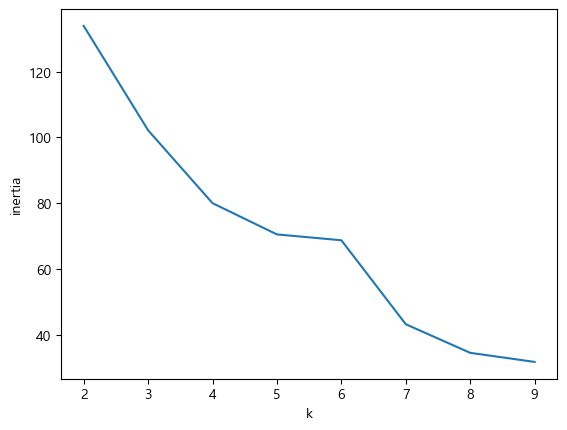

In [25]:
# k를 2부터 10까지 해서 최적의 k 값 찾기
inertia = []

for k in range(2,10) :
    km = KMeans(n_clusters = k, random_state = 26)
    km.fit(x_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2, 10), inertia)
plt.xlabel("k")
plt.ylabel("inertia")
plt.show()

- 엘보우기법기반으로 k 값을 찾으면 6이 최적의 하이퍼파라미터이지만 군집에 1개의 자치구가 있는 문제가 생김(너무 세밀하게 나눔)
- k값을 2 ~ 5까지 클러스터링을 해보고 적절하게 군집에 나누어지는 k 값을 찾음
- 제대로 군집이 나눠지는 값은 3임

In [28]:
# k를 3으로 넣고 k-means 모델생성
model = KMeans(n_clusters = 3, random_state = 26,  n_init=10)

In [30]:
# 정규환된 입력변수를 이용해서 모델 학습
model.fit(x_scaled)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=3, n_init=10, random_state=26)

In [32]:
# 0,1,2로 라벨링이되어있음
np.unique(model.labels_)

array([0, 1, 2])

In [34]:
group = df.copy()

In [36]:
# 클러스터링이 진행되고나서 진행된 값을 cluster라는 컬럼에 넣음
group["cluster"] = model.predict(x_scaled)

In [38]:
group = group.sort_values("cluster").reset_index(drop=True)

In [40]:
group

,자치구,시간_구분,대여_건수,반납_건수,|대여-반납|,빈대여소의비율,std,빈대여소시간,유출량,유입량,회전율,최대이용량,최소이용량,최대최소_편차,대여소_개수,면적,밀도(개/km²),이동량,cluster
0,중랑구,비활성,27222,28026,804,0.072149,0.002295,1058,379,499,587.744681,24154,1990,22164,106,18.50,5.729730,120,0
1,강동구,비활성,33550,34465,915,0.110790,0.006921,1953,351,482,581.324786,40674,2346,38328,137,24.58,5.573637,131,0
2,강북구,비활성,15216,14907,309,0.120085,0.006457,1124,349,387,502.050000,10667,1473,9194,69,23.61,2.922490,38,0
3,관악구,비활성,24605,24254,351,0.124166,0.007883,1414,356,432,642.881579,18205,2032,16173,95,29.57,3.212716,76,0
4,은평구,비활성,20081,21524,1443,0.137464,0.008013,2123,212,355,424.540816,20977,1358,19619,115,29.69,3.873358,143,0
5,구로구,비활성,27885,29049,1164,0.104082,0.014443,1851,489,638,495.078261,43786,2422,41364,124,20.12,6.163022,149,0
6,금천구,비활성,9418,10418,1000,0.100152,0.002403,1119,132,208,264.480000,20862,719,20143,79,13.00,6.076923,76,0
7,노원구,비활성,49490,48514,976,0.143263,0.012821,3330,675,697,649.033113,51828,3439,48389,170,35.44,4.796840,22,0
8,도봉구,비활성,18979,20405,1426,0.092834,0.008479,1064,385,572,525.120000,20121,1593,18528,95,20.70,4.589372,187,0
9,동작구,비활성,18573,19911,1338,0.089972,0.005741,1004,444,691,520.054054,16527,1542,14985,83,16.35,5.076453,247,0


In [42]:
group["cluster"].value_counts()

cluster
0    14
2     7
1     4
Name: count, dtype: int64

### 클러스터링 결과 
- 3개로 자치구를 나눴을 때 0번 : 14개, 2번 7개, 1번 3개 이렇게 클러스터링 결과가 나옴

## 각 클러스터들을 특징 파악
- 각 클러스터들의 평균을 구하고 비교 분석

In [46]:
# cluster_means는 각각 클러스터의 평균
# all_means는 전체 평균
cluster_means = group.groupby("cluster")[select].mean(numeric_only=True)
all_means = group[select].mean().to_frame().T

In [48]:
all_means

,|대여-반납|,빈대여소의비율,빈대여소시간,회전율,최대최소_편차,밀도(개/km²),이동량
0,1276.0,0.174104,2985.76,517.739253,36150.56,5.560727,117.28


In [50]:
cluster_means

,|대여-반납|,빈대여소의비율,빈대여소시간,회전율,최대최소_편차,밀도(개/km²),이동량
cluster,,,,,,,
0,1001.357143,0.128789,1921.071429,491.946141,25096.500000,4.817927,118.428571
1,1240.250000,0.375038,6217.750000,301.436300,24562.250000,6.224261,37.500000
2,1845.714286,0.149915,3268.285714,692.927165,64880.571429,6.667163,160.571429


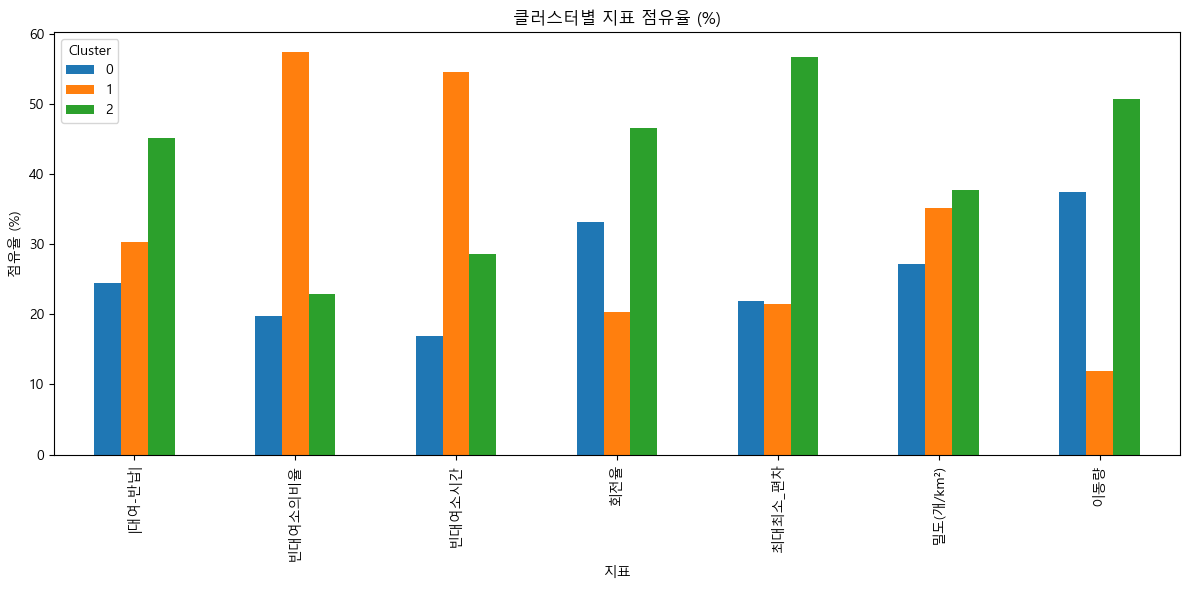

In [52]:
# 3개의 클러스터를 100분율로 계산
share = cluster_means.div(cluster_means.sum(axis=0), axis=1) * 100

share.T.plot(kind="bar", figsize=(12,6)) #bar형태로 그림

plt.title("클러스터별 지표 점유율 (%)")
plt.xlabel("지표")
plt.ylabel("점유율 (%)")
plt.legend(title="Cluster")
plt.tight_layout()

plt.show()

## 컬럼별 분석

- 전체 평균과 각 클러스터의 평균 값을 비교분석

- 따릉이 수요 불균형을 나타내는 컬럼들을 살펴봄
  1. |대여-반납|
  2. 빈대여소의 비율, 빈대여소시간
  3. 이동량
  4. 최대최소_편차

## |대여-반납|

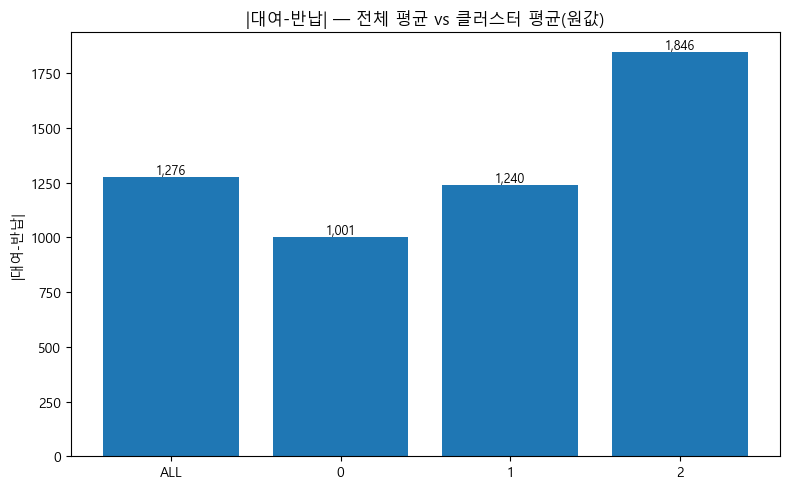

In [56]:
metric = "|대여-반납|"

# 전체 평균(ALL) 스칼라 추출
overall = all_means.squeeze()[metric]   

# 클러스터별 평균 Series
cm = cluster_means[metric]              

# 간단한 요약(개수)
above = (cm > overall).sum()
below = (cm < overall).sum()
equal = (cm == overall).sum()

# 막대그래프 
labels = ["ALL"] + [str(c) for c in cm.index]
values = [overall] + cm.tolist()

x = np.arange(len(labels))
plt.figure(figsize=(8,5))
plt.bar(x, values)
plt.xticks(x, labels)
plt.ylabel(metric)
plt.title(f"{metric} — 전체 평균 vs 클러스터 평균(원값)")

# 값 라벨 표시
for xi, v in zip(x, values):
    plt.text(xi, v, f"{v:,.0f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


## 빈대여소의비율

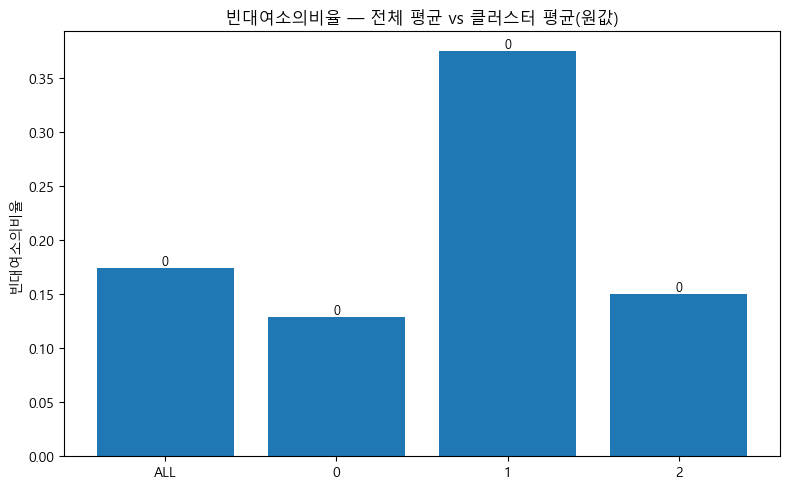

In [59]:
metric = "빈대여소의비율"

# 전체 평균(ALL) 스칼라 추출
overall = all_means.squeeze()[metric]   

# 클러스터별 평균 Series
cm = cluster_means[metric]             

# 간단한 요약(개수)
above = (cm > overall).sum()
below = (cm < overall).sum()
equal = (cm == overall).sum()

# 막대그래프 
labels = ["ALL"] + [str(c) for c in cm.index]
values = [overall] + cm.tolist()

x = np.arange(len(labels))
plt.figure(figsize=(8,5))
plt.bar(x, values)
plt.xticks(x, labels)
plt.ylabel(metric)
plt.title(f"{metric} — 전체 평균 vs 클러스터 평균(원값)")

# 값 라벨 표시
for xi, v in zip(x, values):
    plt.text(xi, v, f"{v:,.0f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

## 빈대여소시간

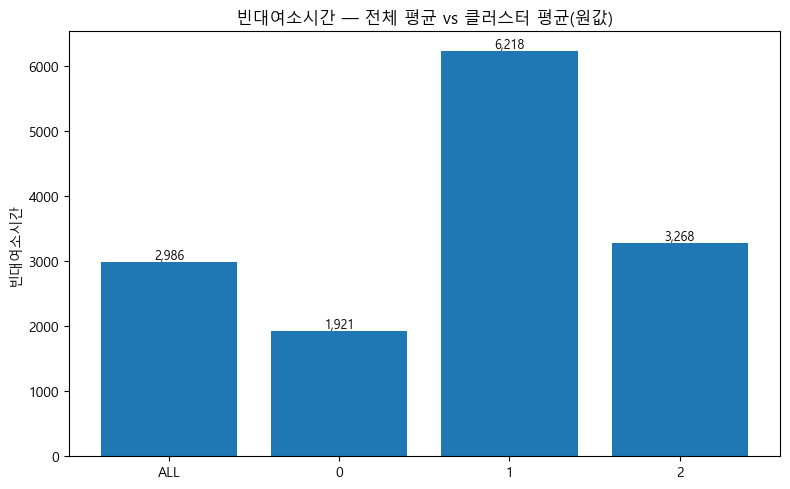

In [62]:
metric = "빈대여소시간"

# 전체 평균(ALL) 스칼라 추출
overall = all_means.squeeze()[metric]   

# 클러스터별 평균 Series
cm = cluster_means[metric]              

# 간단한 요약(개수)
above = (cm > overall).sum()
below = (cm < overall).sum()
equal = (cm == overall).sum()

# 막대그래프 
labels = ["ALL"] + [str(c) for c in cm.index]
values = [overall] + cm.tolist()

x = np.arange(len(labels))
plt.figure(figsize=(8,5))
plt.bar(x, values)
plt.xticks(x, labels)
plt.ylabel(metric)
plt.title(f"{metric} — 전체 평균 vs 클러스터 평균(원값)")

# 값 라벨 표시
for xi, v in zip(x, values):
    plt.text(xi, v, f"{v:,.0f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

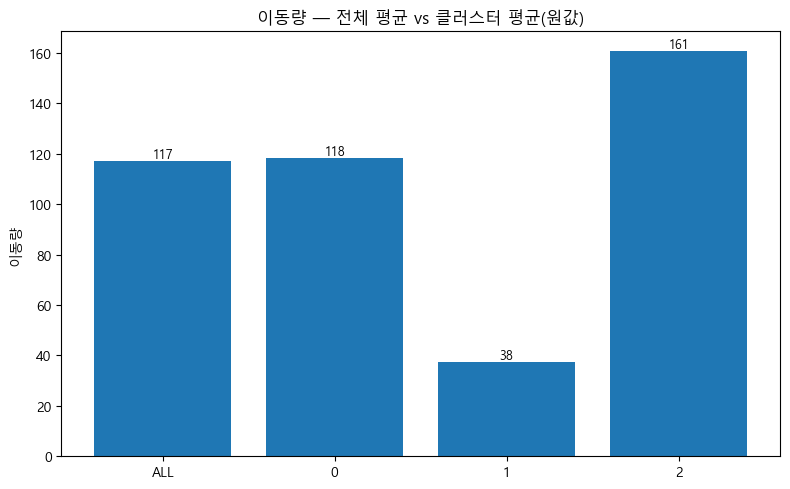

In [64]:
metric = "이동량"

# 전체 평균(ALL) 스칼라 추출
overall = all_means.squeeze()[metric]   

# 클러스터별 평균 Series
cm = cluster_means[metric]             

# 간단한 요약(개수)
above = (cm > overall).sum()
below = (cm < overall).sum()
equal = (cm == overall).sum()

# 막대그래프 
labels = ["ALL"] + [str(c) for c in cm.index]
values = [overall] + cm.tolist()

x = np.arange(len(labels))
plt.figure(figsize=(8,5))
plt.bar(x, values)
plt.xticks(x, labels)
plt.ylabel(metric)
plt.title(f"{metric} — 전체 평균 vs 클러스터 평균(원값)")

# 값 라벨 표시
for xi, v in zip(x, values):
    plt.text(xi, v, f"{v:,.0f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

## 최대최소_편차

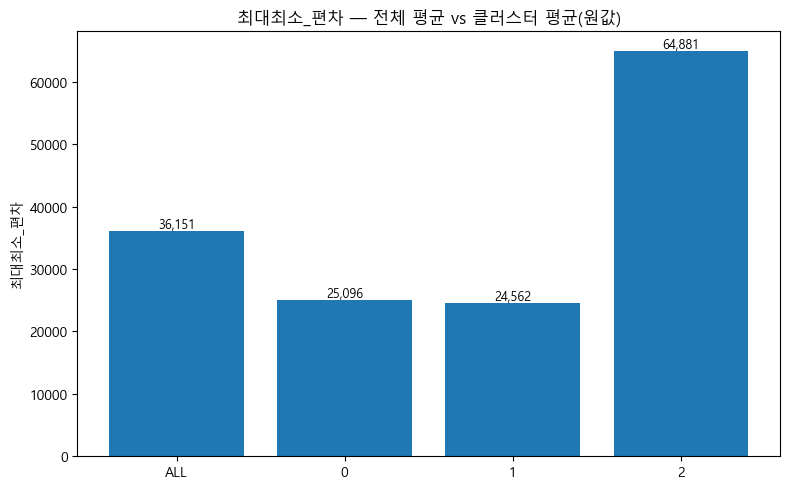

In [67]:
metric = "최대최소_편차"

# 전체 평균(ALL) 스칼라 추출
overall = all_means.squeeze()[metric]   

# 클러스터별 평균 Series
cm = cluster_means[metric]             

# 간단한 요약(개수)
above = (cm > overall).sum()
below = (cm < overall).sum()
equal = (cm == overall).sum()

# 막대그래프 
labels = ["ALL"] + [str(c) for c in cm.index]
values = [overall] + cm.tolist()

x = np.arange(len(labels))
plt.figure(figsize=(8,5))
plt.bar(x, values)
plt.xticks(x, labels)
plt.ylabel(metric)
plt.title(f"{metric} — 전체 평균 vs 클러스터 평균(원값)")

# 값 라벨 표시
for xi, v in zip(x, values):
    plt.text(xi, v, f"{v:,.0f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

- 0번 클러스터
  - 이동량이 많고 회전율은 중상, 빈대여소 문제도 중간
  - 수요 규모는 꽤 되지만 구조적 불균형은 심하지 않은 지역구들
 
- 1번 클러스터
  - 빈 대여소 비율, 지속시간이 가장 높고 회전율 이동량은 낮은 공급부족형
  - 전반 지표가 과열은 아니지만 재고 고갈이 잦아 지속적인 재배치가 필요
 
- 2번 클러스터
  - 회전율, 최대-최소 편차 이동량이 모두 최고조로 불균형이 큼
  - 피크 시간대 급등락과 변동성이 매우 두드러짐